# to do:
* change edge ordering criteria + keep base choice / random as standard
* add more edge ordering criteria for kelmans sensitivity to edge ordering in reduction analysis
* analyse cl, reduction, kelmans results over cheeger cste and spectral radius

**04/04**\
added edge ordering to reduction
- switched to heap + dynamically modified heaps from deque


In [21]:
import networkx as nx
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from collections import deque
import example_graphs as ex
import cluster_refinement as refinement
import visual_aids as vis
import spectral_embedding as se

In [2]:
def draw(G, title):
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='black')
    plt.title(f"{title}")
    plt.show()

In [3]:
def aggressive_pruning(G, threshold=2):
    H = G.copy()
    n = G.number_of_nodes()
    candidates = deque(list(H.edges()))
    while candidates:
        u, v = candidates.popleft()
        if not H.has_edge(u, v): #remove if edge doesn't exist anymore
            continue
        if H.degree(u) + H.degree(v) < n + threshold:
            continue
        else:
            H.remove_edge(u, v)
            #print(f"removing edge {u}-{v}")
            #draw(H)
            for w in list(H.neighbors(u)):
                candidates.append((u, w))
            for w in list(H.neighbors(v)):
                candidates.append((v, w))
    
    #plt.show()
    return H

## reductions of $G$ with different pruning order

In [4]:
def cheeger_cut(G):
    L = nx.laplacian_matrix(G)
    _, vecs = sp.linalg.eigsh(L, k=2, which='SM')
    fiedler = vecs[:, 1]

    idx = np.argsort(fiedler)
    nodes = np.array(G.nodes())[idx]
    
    in_S = np.zeros(len(nodes), dtype=bool)
    vol_S = 0
    boundary = 0
    degrees = np.array(A.sum(axis=1)).flatten()
    
    min_ratio = np.inf
    best_cut = set()
    
    for i in range(len(nodes) // 2):
        v = nodes[i]
        v_idx = list(G.nodes).index(v)
        in_S[v_idx] = True
        vol_S += degrees[v_idx]

        for u in G.neighbors(v):
            u_idx = list(G.nodes).index(u)
            if in_S[u_idx]:
                boundary -= 1
            else:
                boundary += 1

        if vol_S > 0:
            ratio = boundary / vol_S
            if ratio < min_ratio:
                min_ratio = ratio
                best_cut = set(nodes[:i+1])

    return min_ratio, best_cut

def boundary_edges(G, cut_set):
    cut_set = set(cut_set)
    return [
        (u, v)
        for u, v in G.edges()
        if (u in cut_set) != (v in cut_set)
    ]

In [5]:
def plot_cheeger_cut(G, cut_set):
    other_set = set(G.nodes()) - cut_set
    boundary = boundary_edges(G, cut_set)

    pos = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(8, 6))

    nx.draw_networkx_nodes(G, pos, nodelist=cut_set, node_color='skyblue', label='split 1')
    nx.draw_networkx_nodes(G, pos, nodelist=other_set, node_color='lightgreen', label='split 2')

    internal_edges = [e for e in G.edges() if e not in boundary and (e[1], e[0]) not in boundary]
    nx.draw_networkx_edges(G, pos, edgelist=internal_edges, edge_color='gray')
    nx.draw_networkx_edges(G, pos, edgelist=boundary, edge_color='red', label='boundary edges')

    nx.draw_networkx_labels(G, pos)
    plt.title("cheeger cut")
    plt.axis('off')
    plt.legend()
    plt.show()

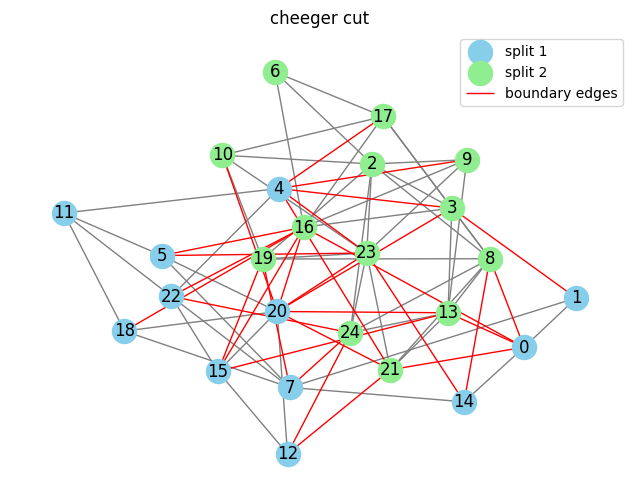

In [6]:
# test
G = ex.test_graph(25)
L, Q, n, A = se.compute_normalized(G)
cheeger_cste, cut = cheeger_cut(G)
plot_cheeger_cut(G,cut)

### pruning order
* we start with a list of all edges of $G$

In [7]:
def get_edge_attributes(G, cut_set):
    degrees = dict(G.degree())
    boundary_flags = {
        (min(u, v), max(u, v)): (u in cut_set) != (v in cut_set)
        for u, v in G.edges()
    }
    degree_diffs = {
        (min(u, v), max(u, v)): abs(degrees[u] - degrees[v])
        for u, v in G.edges()
    }

    return boundary_flags, degree_diffs

In [8]:
def combined_edge_priority(e, boundary_flags, degree_diffs, alpha=1.0, beta=0.0, gamma=0.0, normalize=False):
    key = (min(e[0], e[1]), max(e[0], e[1]))
    b = int(boundary_flags[key])
    d = degree_diffs[key]
    if normalize:
        d /= max(degree_diffs.values()) or 1
    return alpha * b + beta * d

In [9]:
def spectral_radius(G):
    A = se.computeA(G)
    val, _ = sp.linalg.eigsh(A, k=1, which='LA')
    return val[0]

In [10]:
import heapq
def aggressive_pruning_ordered(G, alpha=1.0, beta=0.0, normalize=False, threshold=2):
    H = G.copy()
    n = G.number_of_nodes()
    h, cut = cheeger_cut(G)
    boundary_flags, degree_diffs = get_edge_attributes(G, cut)
    seen = set()
    heap = []
    for e in H.edges():
        prio = combined_edge_priority(e, boundary_flags, degree_diffs, alpha, beta, normalize)
        heapq.heappush(heap, (prio, e))

    while heap:
        _, (u, v) = heapq.heappop(heap)
        eid = (min(u, v), max(u, v))
        if eid in seen or not H.has_edge(u, v):
            continue
        seen.add(eid)
        if H.degree(u) + H.degree(v) < n + threshold:
            continue
        H.remove_edge(u, v)
        for w in list(H.neighbors(u)):
            ew = (min(u, w), max(u, w))
            if ew not in seen:
                prio = combined_edge_priority((u, w), boundary_flags, degree_diffs, alpha, beta, normalize)
                heapq.heappush(heap, (prio, (u, w)))
        for w in list(H.neighbors(v)):
            ew = (min(v, w), max(v, w))
            if ew not in seen:
                prio = combined_edge_priority((v, w), boundary_flags, degree_diffs, alpha, beta, normalize)
                heapq.heappush(heap, (prio, (v, w)))
    return H

In [27]:
strat = [
        # format (boundary, degree diff)
        (1.0, 0.0),
        (-1.0, 0.0),
        (0.0, 1.0),
        (0.0, -1.0),
        (1.0, 1.0),
        (-1.0, -1.0)
    ]
def variable_orderings(G, strat):
    strategies = strat
    results = {}
    for alpha, beta in strategies:
        key = (alpha, beta)
        pruned = aggressive_pruning_ordered(G, alpha=alpha, beta=beta, normalize=True)
        h, _ = cheeger_cut(pruned)
        rho = spectral_radius(pruned)
        edge_count = pruned.number_of_edges()

        results[key] = {
            'cheeger': h,
            'spectral_radius': rho,
            'edge_count': edge_count,
            'graph': pruned
        }
        print(f"strat (condition coefficients): boundary {key[0]}, degree diff {key[1]}")
        print(f"cheeger cste: {h:.4f}")
        print(f"spectral radius:  {rho:.4f}\n")
        print(f"number of edges: {pruned.number_of_edges()}")
        pos = nx.kamada_kawai_layout(pruned)
        nx.draw(pruned, pos, with_labels=True, node_color='lightblue', edge_color='black')
        plt.title(f"{key}\ncheeger ≈ {h:.4f}, ρ ≈ {rho:.4f}, edge count = {edge_count}")
        plt.show()
    return results

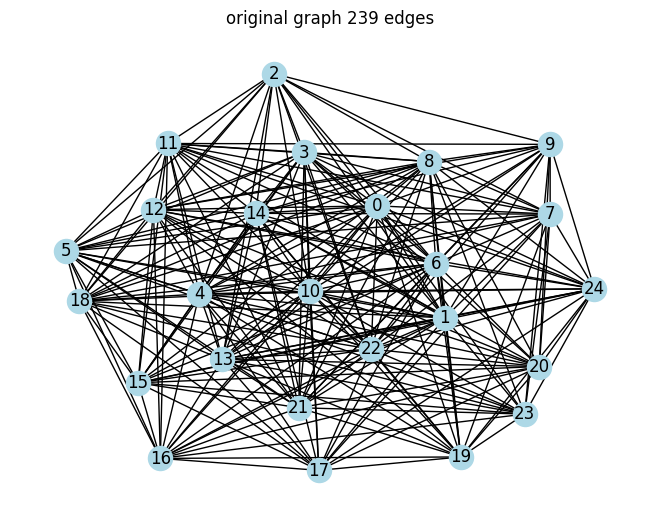

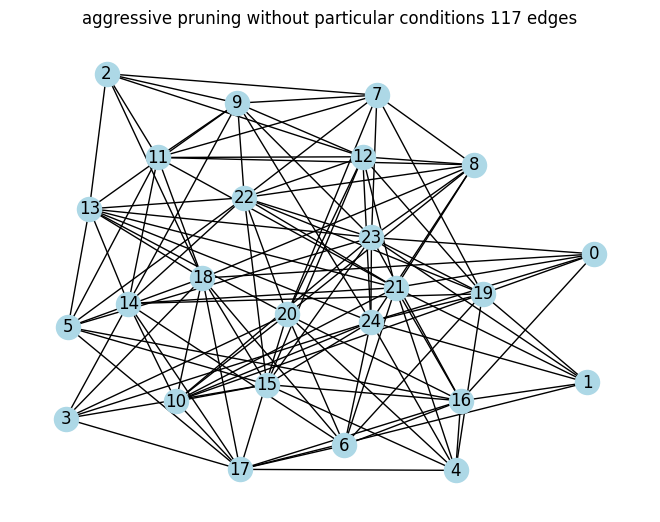

strat (condition coefficients): boundary 1.0, degree diff 0.0
cheeger cste: 0.2523
spectral radius:  11.2677

number of edges: 139


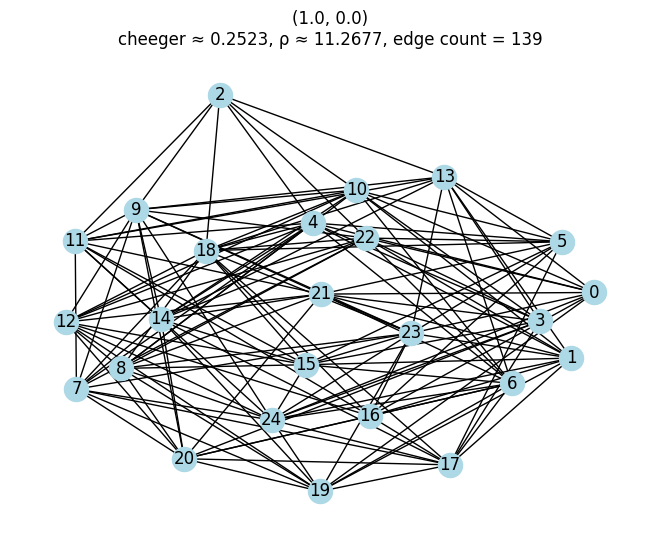

strat (condition coefficients): boundary -1.0, degree diff 0.0
cheeger cste: 0.0622
spectral radius:  11.6792

number of edges: 143


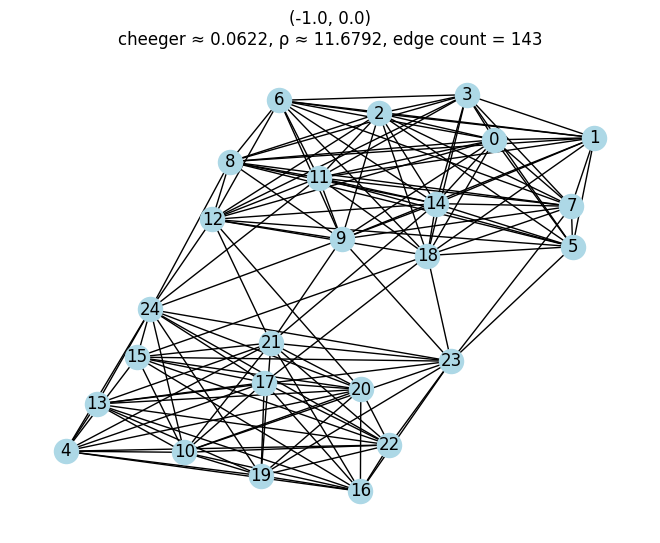

strat (condition coefficients): boundary 0.0, degree diff 1.0
cheeger cste: 0.2544
spectral radius:  11.8158

number of edges: 147


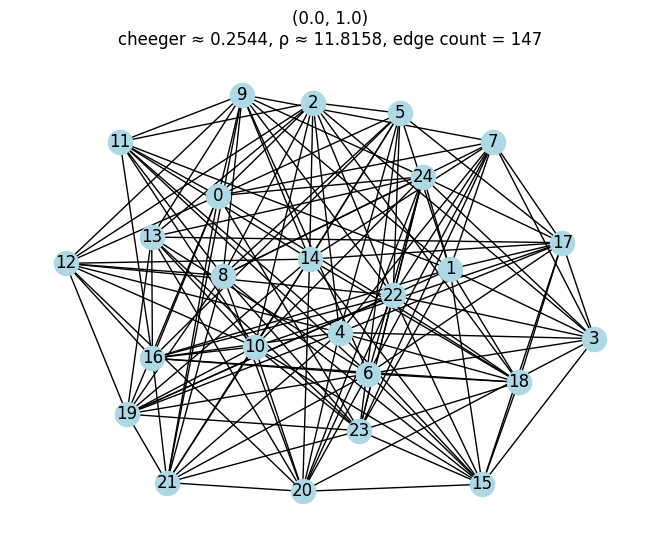

strat (condition coefficients): boundary 0.0, degree diff -1.0
cheeger cste: 0.0791
spectral radius:  10.4914

number of edges: 128


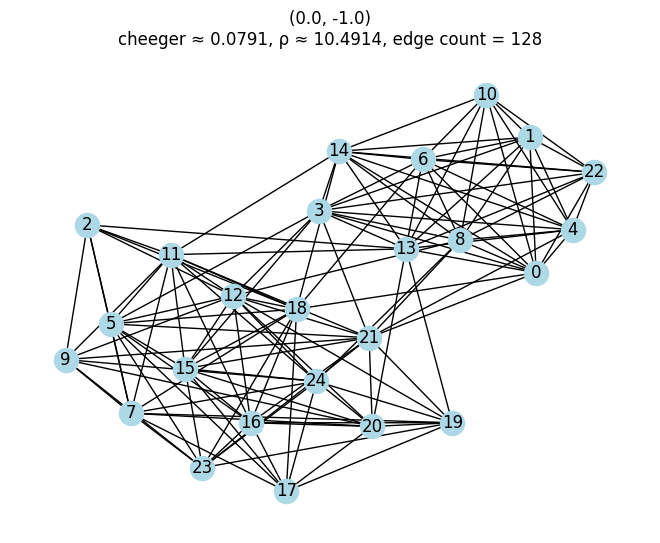

strat (condition coefficients): boundary 1.0, degree diff 1.0
cheeger cste: 0.2555
spectral radius:  11.6970

number of edges: 145


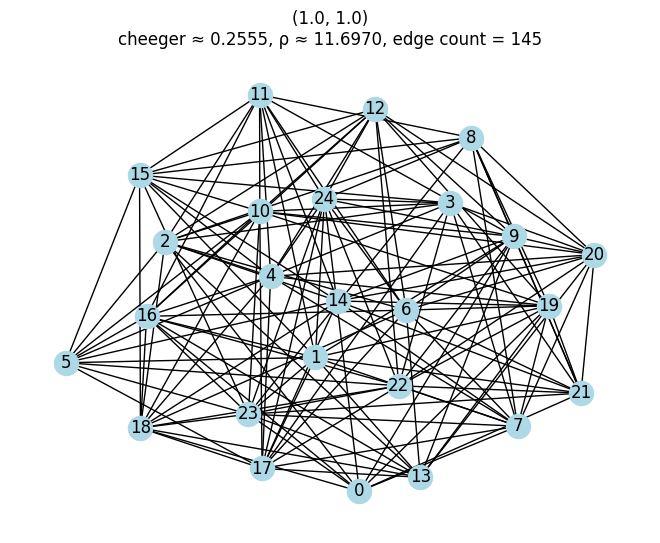

strat (condition coefficients): boundary -1.0, degree diff -1.0
cheeger cste: 0.1116
spectral radius:  10.7470

number of edges: 131


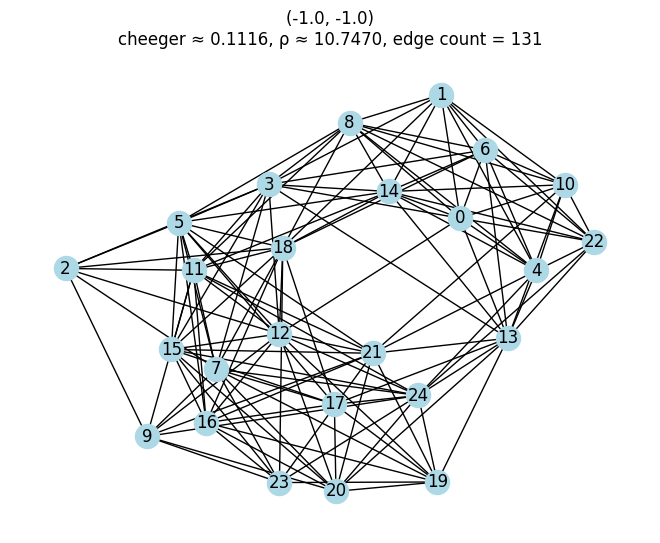

In [12]:
G = ex.test_graph_sparsity(25, 0.2)
L, Q, n, A = se.compute_normalized(G)
pruned = aggressive_pruning(G)
draw(G, f"original graph {G.number_of_edges()} edges")
draw(pruned, f"aggressive pruning without particular conditions {pruned.number_of_edges()} edges")

results = variable_orderings(G)

In [25]:
kelmans_res = results.copy()
for res in results.items():
    graph = res[1]['graph']
    modifs = refinement.all_modifications(graph)
    kelmans_res[res[0]]["kelmans"] = modifs
print(kelmans_res)

{(1.0, 0.0): {'cheeger': np.float64(0.25225225225225223), 'spectral_radius': np.float64(11.267694368095793), 'edge_count': 139, 'graph': <networkx.classes.graph.Graph object at 0x1297f4dd0>, 'kelmans_all': {'no changes': 161, 'isomorphic': 0, 'has_pendent_edge': 15, 'has_weak_edge': 0, 'is_disconnected': 0, 'other': 124}, 'kelmans': {'no changes': 161, 'isomorphic': 0, 'has_pendent_edge': 15, 'has_weak_edge': 0, 'is_disconnected': 0, 'other': 124}}, (-1.0, 0.0): {'cheeger': np.float64(0.06222222222222222), 'spectral_radius': np.float64(11.679243857734635), 'edge_count': 143, 'graph': <networkx.classes.graph.Graph object at 0x1280a7330>, 'kelmans_all': {'no changes': 160, 'isomorphic': 27, 'has_pendent_edge': 0, 'has_weak_edge': 0, 'is_disconnected': 0, 'other': 113}, 'kelmans': {'no changes': 160, 'isomorphic': 27, 'has_pendent_edge': 0, 'has_weak_edge': 0, 'is_disconnected': 0, 'other': 113}}, (0.0, 1.0): {'cheeger': np.float64(0.2543859649122807), 'spectral_radius': np.float64(11.815

* we want to be able to choose a priority strat for the aggressive reduction such that the resulting graph is sensitive to kelmans op

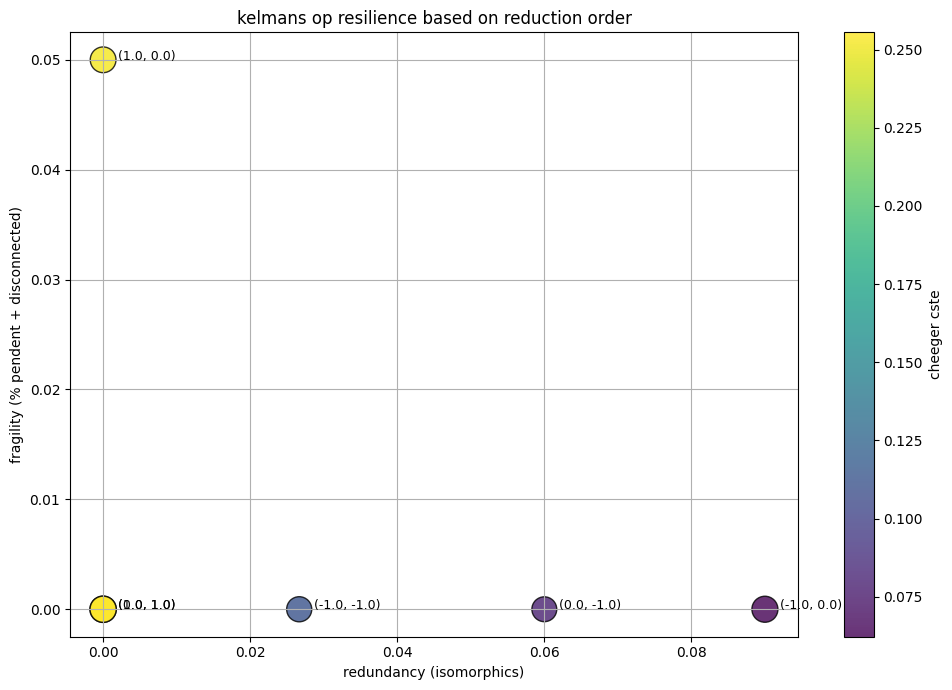

In [ ]:
x_vals, y_vals, cheegers, sizes, labels = [], [], [], [], []

for strat, data in kelmans_res.items():
    counts = data['kelmans']
    total = sum(counts.values())
    iso = counts.get('isomorphic', 0) / total
    frag = (counts.get('has_pendent_edge', 0) + counts.get('is_disconnected', 0)) / total
    x_vals.append(iso)
    y_vals.append(frag)
    cheegers.append(data['cheeger'])
    sizes.append(data['edge_count'])
    labels.append(str(strat))

max_size = max(sizes)
sizes = [60 + 300 * (s / max_size) for s in sizes] 

plt.figure(figsize=(10, 7))
scatter = plt.scatter(x_vals, y_vals, c=cheegers, s=sizes, cmap='viridis', alpha=0.8, edgecolor='k')

for i, label in enumerate(labels):
    plt.text(x_vals[i] + 0.002, y_vals[i], label, fontsize=9)

plt.xlabel("redundancy (%isomorphics)")
plt.ylabel("fragility (% pendent + disconnected)")
plt.title("kelmans op resilience based on reduction order (coeff cheeger boundary, degree diff)")
plt.colorbar(scatter, label='cheeger cste')
plt.grid(True)
plt.tight_layout()
plt.show()

### on complete graphs

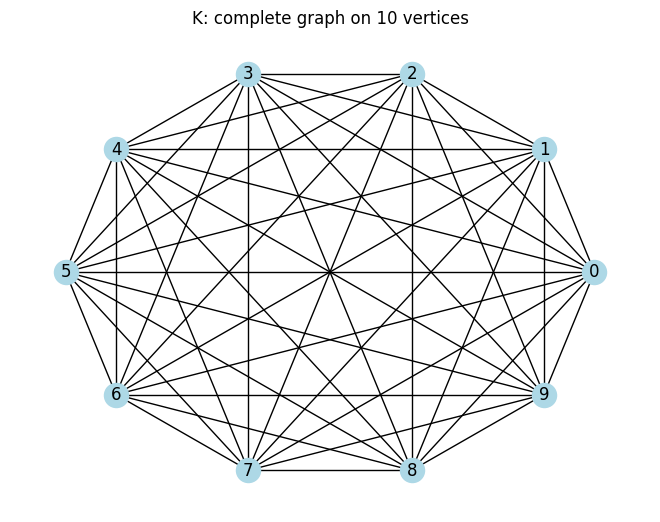

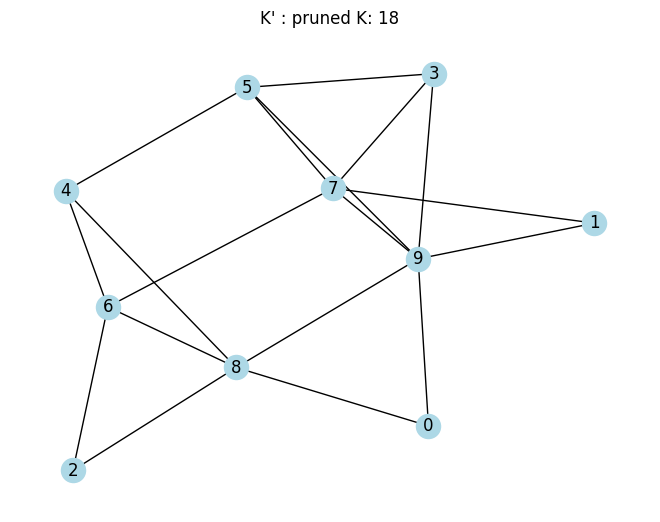

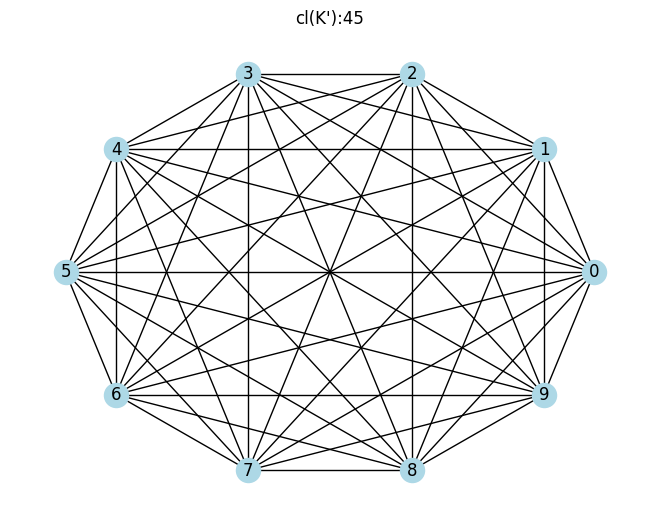

In [14]:
n=10
G = nx.complete_graph(n)
draw(G, f"K: complete graph on {n} vertices")
pruned = aggressive_pruning(G)
draw(pruned, f"K' : pruned K: {pruned.number_of_edges()}")
cl = refinement.bondy_chvatal_closure(pruned)
draw(cl, f"cl(K'):{cl.number_of_edges()}")

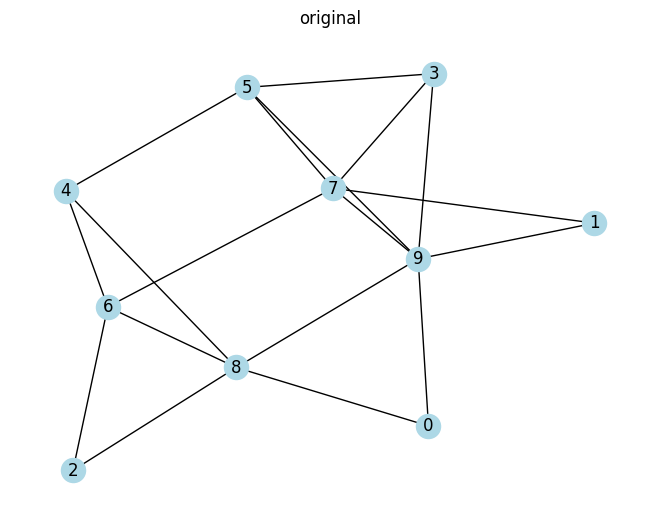

In [15]:
draw(pruned, "original")
u,v = refinement.select_kelmans_candidate(pruned)

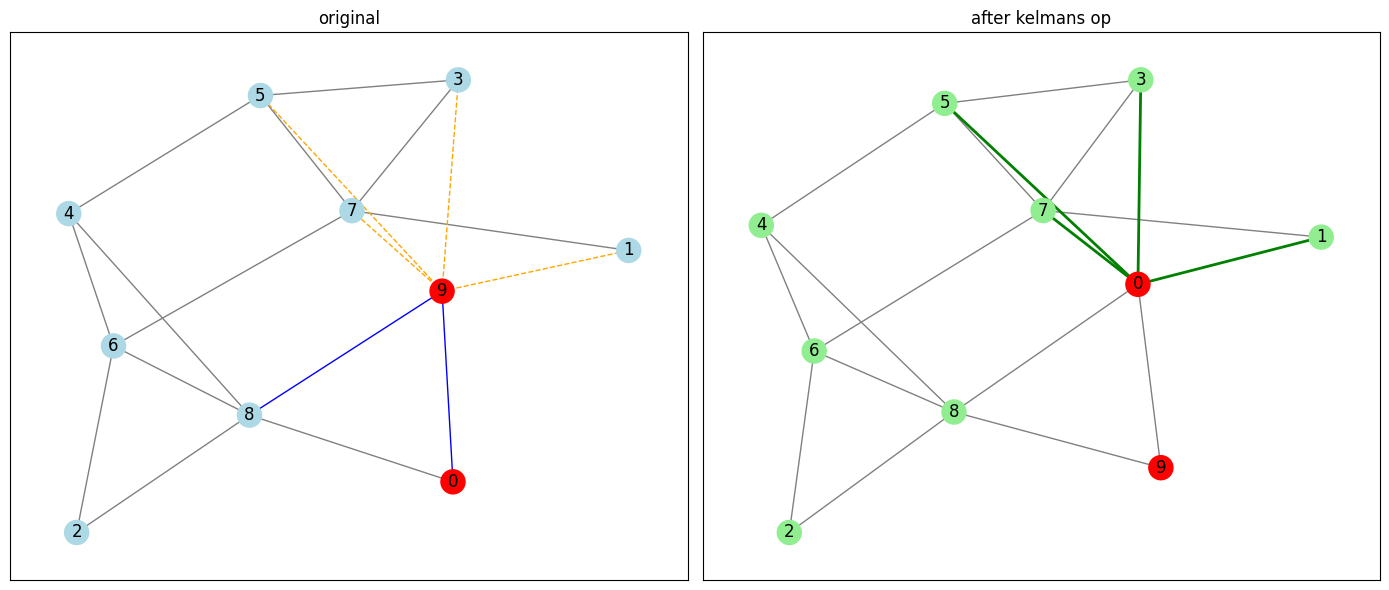

no changes: [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (8, 1), (3, 2), (4, 2), (5, 2), (7, 2), (9, 2), (4, 3), (6, 3), (8, 3), (7, 4), (9, 4), (6, 5), (8, 5), (9, 6), (8, 7)]
isomorphic: [(8, 0), (9, 0), (7, 1), (9, 1), (6, 2), (8, 2), (5, 3), (7, 3), (9, 3)]
shift 5 -> 4, modification type: has_pendent_edge


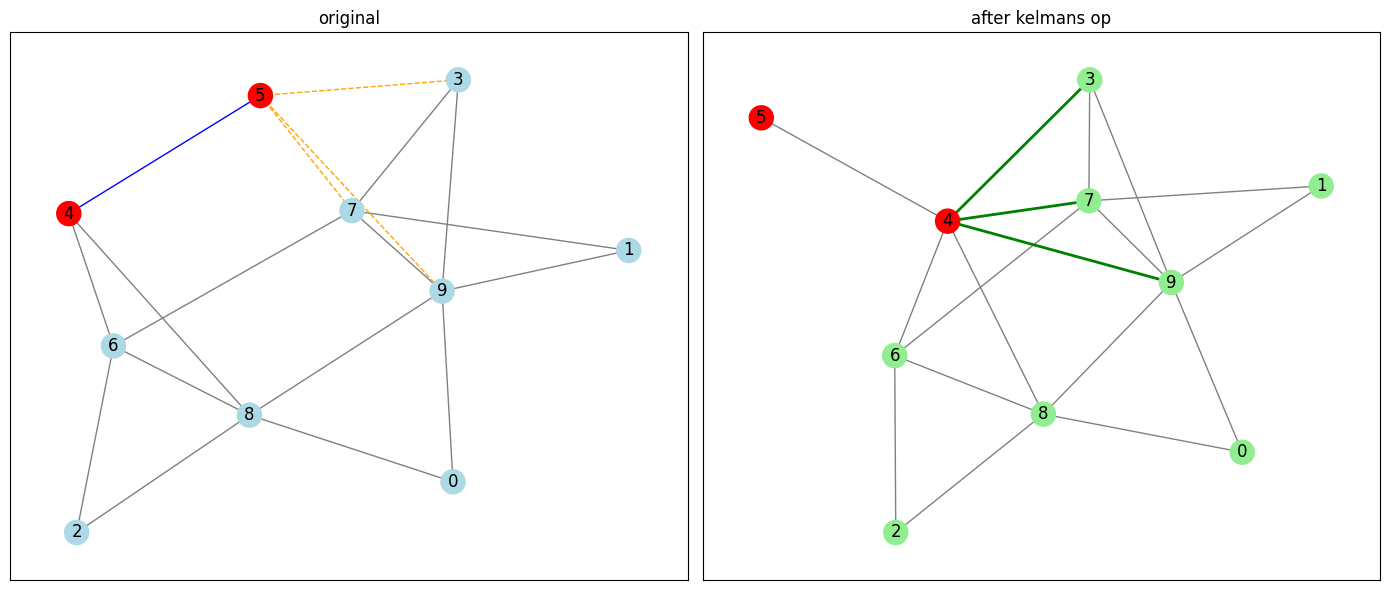

shift 7 -> 6, modification type: has_pendent_edge


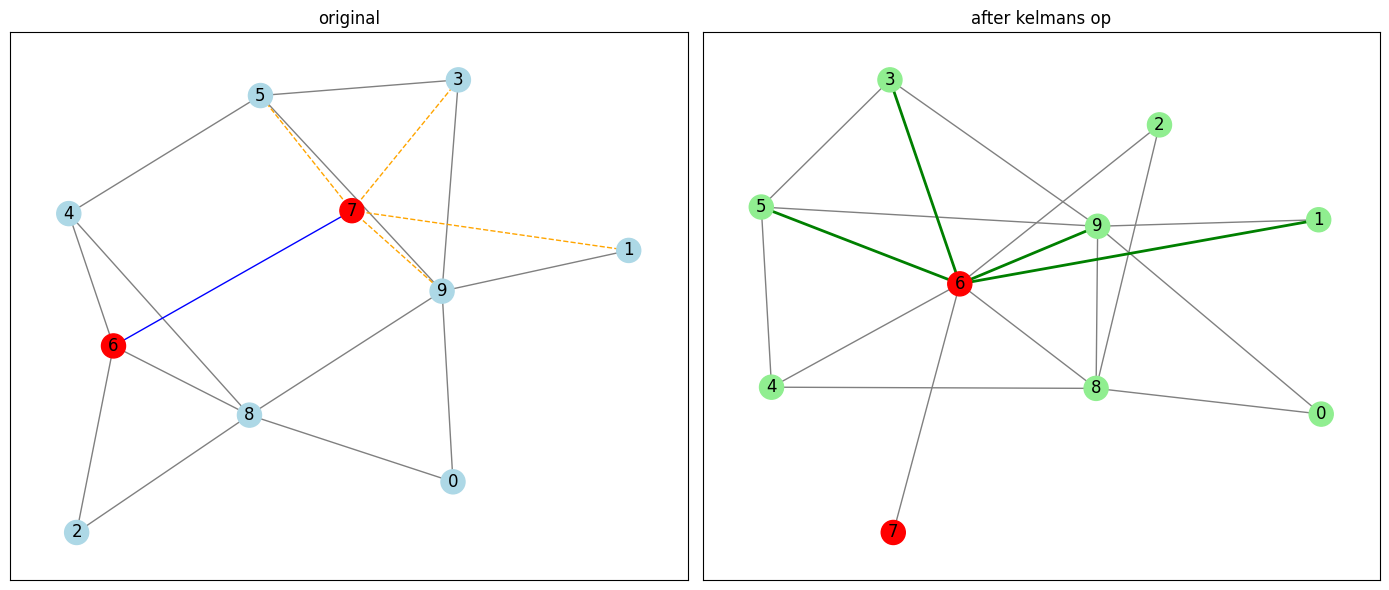

is_disconnected: []
other: [(6, 4), (8, 4), (7, 5), (9, 5), (8, 6), (9, 7), (9, 8)]


In [16]:
vis.visualize_kelmans_operation(pruned, u,v)
vis.test_modifications(pruned)